### Import necessary libaries 

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

### Import data set

In [15]:
# Load the historical profit data 
profit_data = pd.read_csv('profit_data.csv')

In [16]:
profit_data.head(2)

,Date,Profit
0,2015-01-31,13528.104692
1,2015-02-28,10800.314417


### Preprocessing the data

1. Check for any missing values 
2. Stationarity check - Perform ADF test to check the stationarity. What do the results indicate and what steps will you tale to make the data stationary if needed 

In [17]:
profit_data.shape

(60, 2)

In [18]:
profit_data.describe(include="object")

,Date
count,60
unique,60
top,2015-01-31
freq,1


In [19]:
profit_data.isnull().sum()

Date      0
Profit    0
dtype: int64

In [20]:
profit_data.dtypes

Date       object
Profit    float64
dtype: object

In [21]:
# convert the date tp datetime format
profit_data["Date"]=pd.to_datetime(profit_data["Date"])

In [22]:
profit_data.dtypes

Date      datetime64[ns]
Profit           float64
dtype: object

In [23]:
# Set 'Date' column as the index
profit_data.set_index('Date',inplace=True)

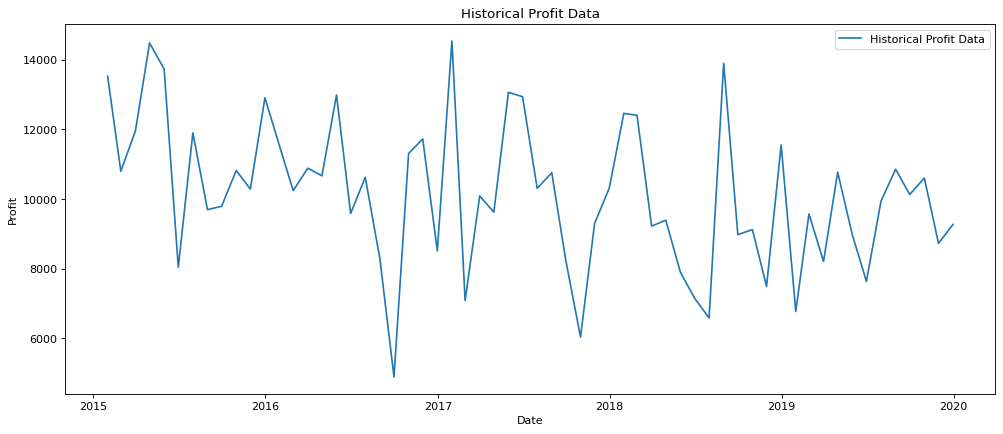

In [24]:
# Visualize the historical profit data
plt.figure(figsize=(15, 6))
plt.plot(profit_data.index, profit_data['Profit'], label='Historical Profit Data')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Historical Profit Data')
plt.legend()
plt.show()

#### Check for stationarity

In [25]:
# Check for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}: {value}')
        
adf_test(profit_data['Profit'])

# Differencing to make the series stationary
profit_data_diff = profit_data.diff().dropna()
adf_test(profit_data_diff['Profit'])

ADF Statistic: -7.047406866009779
p-value: 5.640008260069587e-10
Critical Values:
   1%: -3.5463945337644063
Critical Values:
   5%: -2.911939409384601
Critical Values:
   10%: -2.5936515282964665
ADF Statistic: -4.359630557733871
p-value: 0.0003496614521549568
Critical Values:
   1%: -3.5778480370438146
Critical Values:
   5%: -2.925338105429433
Critical Values:
   10%: -2.6007735310095064


In [26]:
"{:.8f}".format(float("5.640008260069587e-10"))

'0.00000000'

#### Finding the value of the d parameter 

There is no such method that can tell us how much value of d will be optimal. However, the value of differencing can be optimal till 2

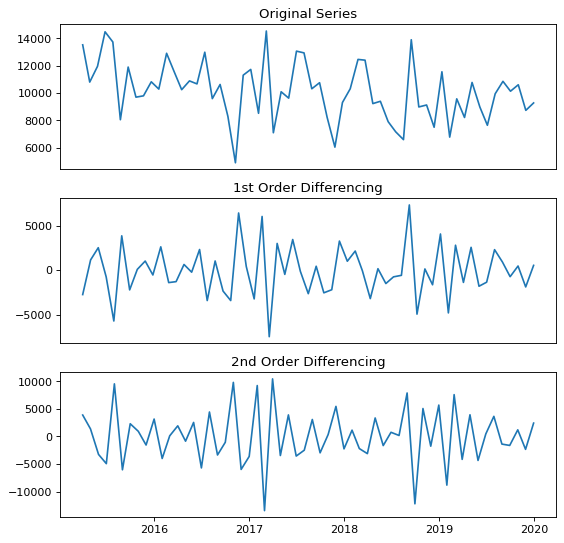

In [27]:
plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':80})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(profit_data.Profit); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)

# 1st Differencing
ax2.plot(profit_data.Profit.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)


# 2nd Differencing
ax3.plot(profit_data.Profit.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

Time series has tried to become stationary. Even zero order (original series) or first-order differencing we have fewer noises in the data while after 1st order there is an increase in the noise. So we can select zero order differencing (original series) for our model. It can be an autocorrelation plot. 

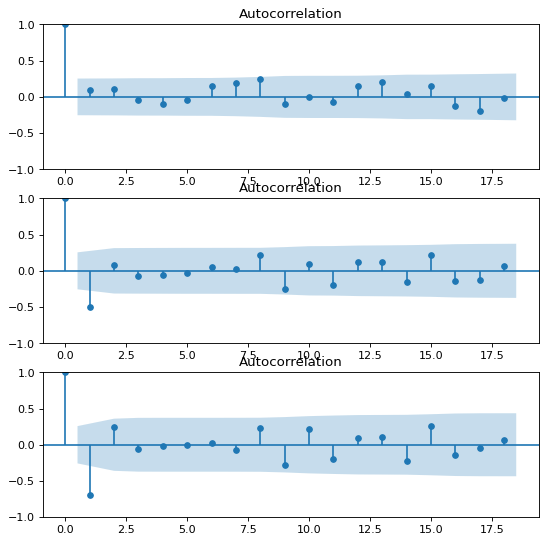

In [49]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams["figure.figsize"] = (8,8)

fig, (ax1, ax2, ax3) = plt.subplots(3)


plot_acf(profit_data.Profit,ax=ax1)
plot_acf(profit_data.Profit.diff().dropna(),ax=ax2)
plot_acf(profit_data.Profit.diff().diff().dropna(), ax=ax3)

plt.show()


Here we can see that in even in first order differencing the immediate lag has gone on the negative side, representing that in the first order the series has become over the difference. 

#### Finding the value of the p parameter

The partial autocorrelation function plot can be used to draw a correlation between the time series and its lag while the contribution from intermediate lags can be ignored. This plotting will let us know about the lags that are not required in the autoregression part.

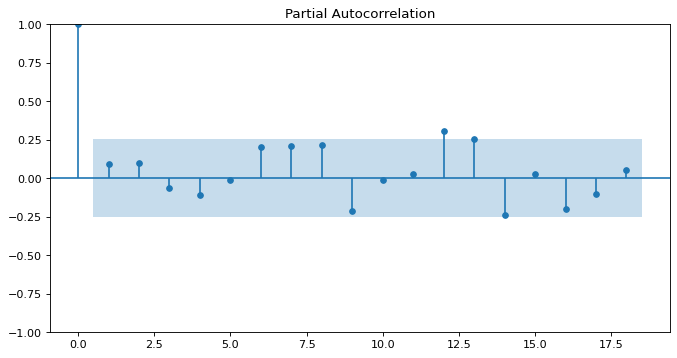

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams["figure.figsize"] = (10,5)

plot_pacf(profit_data.Profit.dropna())

plt.show()


first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1. 

#### Finding the value of the q parameter

To find out the value of q we can use the ACF plot. Which will tell us how much moving average is required to remove the autocorrelation from the stationary time series.

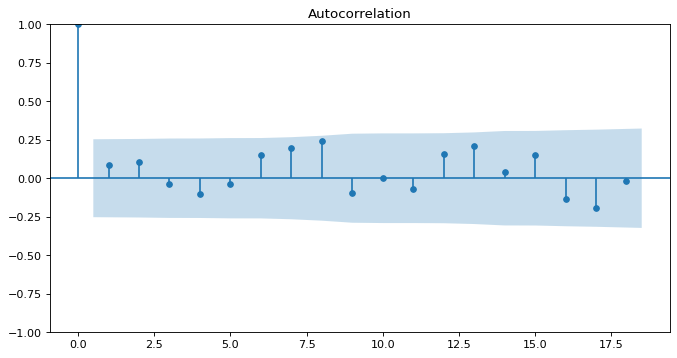

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf


plt.rcParams["figure.figsize"] = (10,5)

plot_acf(profit_data.Profit.dropna())

plt.show()


Here we can see that zero of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is zerp. 

### Model fitting using arima (1,2,1)

Explain the use of choosing parameters (p=1, d=2, q=1). What are the AIC and BIC values of the model and how they help in model evaluation

In [62]:
# Fit ARIMA model
model = ARIMA(profit_data['Profit'], order=(1,2,1))
results = model.fit()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [63]:
# Summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 Profit   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -534.716
Date:                Fri, 31 May 2024   AIC                           1075.431
Time:                        18:28:45   BIC                           1081.560
Sample:                    02-28-2015   HQIC                          1077.813
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3521      0.113     -3.127      0.002      -0.573      -0.131
ma.L1         -0.9999      0.161     -6.193      0.000      -1.316      -0.683
sigma2       7.55e+06   2.14e-08   3.53e+14      0.0

### Model forecasting and diagnistic checks 

2020-01-31     9252.749408
2020-02-29     9429.914063
2020-03-31     9537.027037
2020-04-30     9668.807814
2020-05-31     9791.902140
2020-06-30     9918.055288
2020-07-31    10043.131311
2020-08-31    10168.586631
2020-09-30    10293.908385
2020-10-31    10419.277173
Freq: M, Name: predicted_mean, dtype: float64


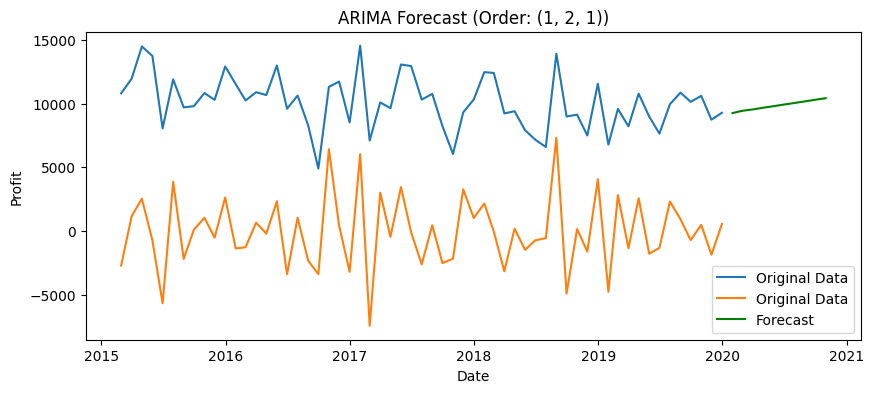

In [66]:
# Make predictions
forecast = results.forecast(steps=10)
print(forecast)

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(profit_data, label='Original Data')
plt.plot(forecast, label='Forecast', color='green')
plt.title('ARIMA Forecast (Order: (1, 2, 1))')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

### MSE 

In [97]:
# Calculate the mean squared error (MSE) for validation
train_size = int(len(profit_data) * 0.8)
train, test = profit_data[0:train_size], profit_data[train_size:]
model = ARIMA(train, order=(2, 1, 2))
results = model.fit()
predictions = results.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2220005.709883736


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Model fitting using arima (1,0,1)

In [83]:
# Fit ARIMA model
model_new = ARIMA(profit_data['Profit'], order=(1,0,1))
results_new = model.fit()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [84]:
# Summary of the model
print(results_new.summary())

                               SARIMAX Results                                
Dep. Variable:                 Profit   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -534.716
Date:                Fri, 31 May 2024   AIC                           1075.431
Time:                        19:23:29   BIC                           1081.560
Sample:                    02-28-2015   HQIC                          1077.813
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3521      0.113     -3.127      0.002      -0.573      -0.131
ma.L1         -0.9999      0.161     -6.193      0.000      -1.316      -0.683
sigma2       7.55e+06   2.14e-08   3.53e+14      0.0

### Model forecasting and diagnistic checks

2020-01-31     9252.749408
2020-02-29     9429.914063
2020-03-31     9537.027037
2020-04-30     9668.807814
2020-05-31     9791.902140
2020-06-30     9918.055288
2020-07-31    10043.131311
2020-08-31    10168.586631
2020-09-30    10293.908385
2020-10-31    10419.277173
Freq: M, Name: predicted_mean, dtype: float64


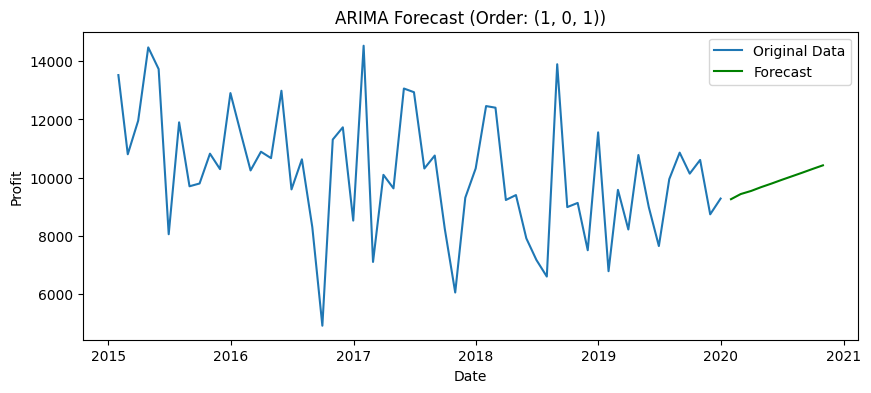

In [86]:
# Make predictions
forecast_new = results_new.forecast(steps=10)
print(forecast)

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(profit_data, label='Original Data')
plt.plot(forecast_new, label='Forecast', color='green')
plt.title('ARIMA Forecast (Order: (1, 0, 1))')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

### MSE 

In [96]:
# Calculate the mean squared error (MSE) for validation
train_size = int(len(profit_data) * 0.8)
train, test = profit_data[0:train_size], profit_data[train_size:]
model = ARIMA(train, order=(2, 1, 2))
results_new = model.fit()
predictions = results_new.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2220005.709883736


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
